In [7]:
# This script computes centrality and memory metrics from protein structures and compares them
# with experimentally derived mutation positions using Spearman correlation, without GNN training.

import os
import gc
import requests
import prody as pr
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm

# === Load Dataset ===
df = pd.read_csv("dataset.csv")
df = df[["pdb_id", "position", "ddG"]].dropna()
df = df[df["pdb_id"].str.len() == 4]
df["label"] = df["ddG"].apply(lambda x: 1 if x < 0 else 0)
df = df.sample(frac=0.3).reset_index(drop=True)  # Shuffle the dataset
print(df.size)

records = []

# === Download PDB ===
def download_pdb(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{pdb_id}.pdb", "w") as f:
            f.write(response.text)
        return f"{pdb_id}.pdb"
    return None

# === Build Graph ===
def build_graph(pdb_file, position, label, ddg, cutoff=7.0):
    structure = pr.parsePDB(pdb_file)
    calphas = structure.select('protein and name CA')
    if calphas is None or len(calphas) < 10:
        return

    coords = calphas.getCoords()
    aa_ids = calphas.getResnums()
    n = len(coords)

    try:
        idx = list(aa_ids).index(int(position))
    except:
        return

    anm = pr.ANM('ANM')
    anm.buildHessian(calphas, cutoff=cutoff)
    anm.calcModes(n_modes=20, turbo=False)
    prs_matrix = pr.calcPerturbResponse(anm)[0]

    G = nx.Graph()
    for i in range(n):
        G.add_node(i, coords=coords[i])
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                k_ij = 1.0 / dist**2
                q_ij = prs_matrix[i, j]
                memory_score = q_ij**2 / k_ij
                G.add_edge(i, j, weight=memory_score)

    memory_scores = {i: sum(d['weight'] for _, _, d in G.edges(i, data=True)) for i in G.nodes()}
    betweenness = nx.betweenness_centrality(G, weight="weight")
    closeness = nx.closeness_centrality(G, distance="weight")
    eigen = nx.eigenvector_centrality_numpy(G, weight="weight")

    records.append({
        "pdb_id": os.path.basename(pdb_file),
        "position": int(position),
        "label": label,
        "ddG": ddg,
        "memory_rank": list(sorted(memory_scores.items(), key=lambda x: x[1], reverse=True)).index((idx, memory_scores.get(idx))) + 1,
        "betweenness_rank": list(sorted(betweenness.items(), key=lambda x: x[1], reverse=True)).index((idx, betweenness.get(idx))) + 1,
        "closeness_rank": list(sorted(closeness.items(), key=lambda x: x[1], reverse=True)).index((idx, closeness.get(idx))) + 1,
        "eigen_rank": list(sorted(eigen.items(), key=lambda x: x[1], reverse=True)).index((idx, eigen.get(idx))) + 1
    })

# === Run Graph Analysis ===
for _, row in tqdm(df.iterrows(), total=len(df)):
    pdb_id, pos, lbl, ddg = row["pdb_id"], row["position"], row["label"], row["ddG"]
    pdb_file = download_pdb(pdb_id)
    if pdb_file:
        build_graph(pdb_file, pos, lbl, ddg)
        os.remove(pdb_file)
    gc.collect()

# === Correlation Analysis ===
result_df = pd.DataFrame(records)
if not result_df.empty:
    print("\n=== Spearman Correlation (Beneficial Mutations: ddG < 0) ===")
    beneficial_df = result_df[result_df["ddG"] < 0]
    for col in ["memory_rank", "betweenness_rank", "closeness_rank", "eigen_rank"]:
        corr, _ = spearmanr(beneficial_df["position"], beneficial_df[col])
        print(f"Spearman correlation between experimental position and {col} (beneficial): {corr:.3f}")

    print("\n=== Spearman Correlation (Non-beneficial Mutations: ddG >= 0) ===")
    nonbeneficial_df = result_df[result_df["ddG"] >= 0]
    for col in ["memory_rank", "betweenness_rank", "closeness_rank", "eigen_rank"]:
        corr, _ = spearmanr(nonbeneficial_df["position"], nonbeneficial_df[col])
        print(f"Spearman correlation between experimental position and {col} (non-beneficial): {corr:.3f}")


/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_2351/1518588753.py:15: DtypeWarning: Columns (23,24,25,26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


3644


  0%|          | 0/911 [00:00<?, ?it/s]@> 545 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.00s.
@> WARNING More than 6 (7) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.01s.
  0%|          | 1/911 [00:00<08:37,  1.76it/s]@> 1729 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Hessian was built in 0.01s.
@> WARNING More than 6 (11) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.07s.
  0%|          | 2/911 [00:01<11:08,  1.36it/s]@> 1463 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Hessian was built in 0.01s.
@> WARNING More than 6 (10) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.03s.
  0%|          | 3/911 [00:02<10:39,  1.42it/s]@> 1076 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Hessian was built in 0.01s.
@> 20 modes were calculated in 0.02


=== Spearman Correlation (Beneficial Mutations: ddG < 0) ===
Spearman correlation between experimental position and memory_rank (beneficial): 0.402
Spearman correlation between experimental position and betweenness_rank (beneficial): 0.169
Spearman correlation between experimental position and closeness_rank (beneficial): 0.243
Spearman correlation between experimental position and eigen_rank (beneficial): 0.282

=== Spearman Correlation (Non-beneficial Mutations: ddG >= 0) ===
Spearman correlation between experimental position and memory_rank (non-beneficial): 0.401
Spearman correlation between experimental position and betweenness_rank (non-beneficial): 0.224
Spearman correlation between experimental position and closeness_rank (non-beneficial): 0.280
Spearman correlation between experimental position and eigen_rank (non-beneficial): 0.277


/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_2351/2382544918.py:28: DtypeWarning: Columns (23,24,25,26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")
  0%|          | 0/304 [00:00<?, ?it/s]@> 3191 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Hessian was built in 0.11s.
@> 20 modes were calculated in 0.17s.
  1%|          | 2/304 [00:03<06:38,  1.32s/it]@> 4253 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Hessian was built in 0.14s.
@> 20 modes were calculated in 0.48s.
  1%|          | 3/304 [00:06<12:30,  2.49s/it]@> 2495 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> Hessian was built in 0.07s.
@> 20 modes were calculated in 0.08s.
  1%|▏         | 4/304 [00:08<11:09,  2.23s/it]@> 660 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.01s.
@> 20 modes were calculated in 0.00s.
  2%|▏         | 5/304 [00:09<08:08,  1.63s/it]@> 636 atoms and 1 coordinate


Confusion Matrix:
[[29  4]
 [10 12]]
Precision: 0.750, Recall: 0.545, F1 Score: 0.632


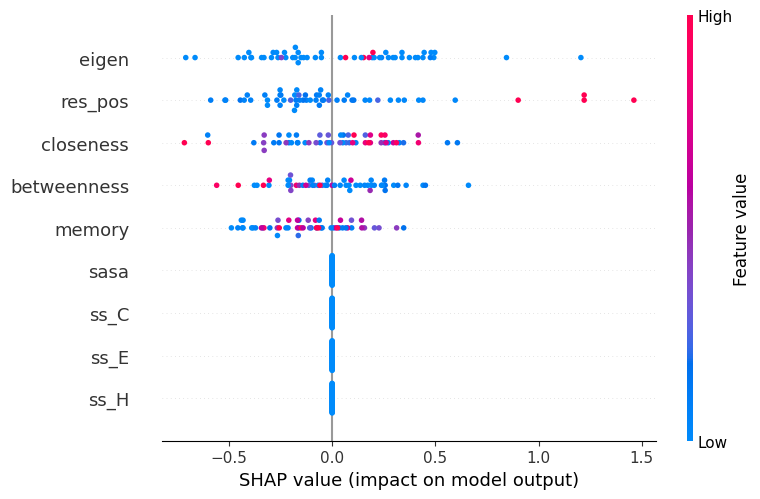

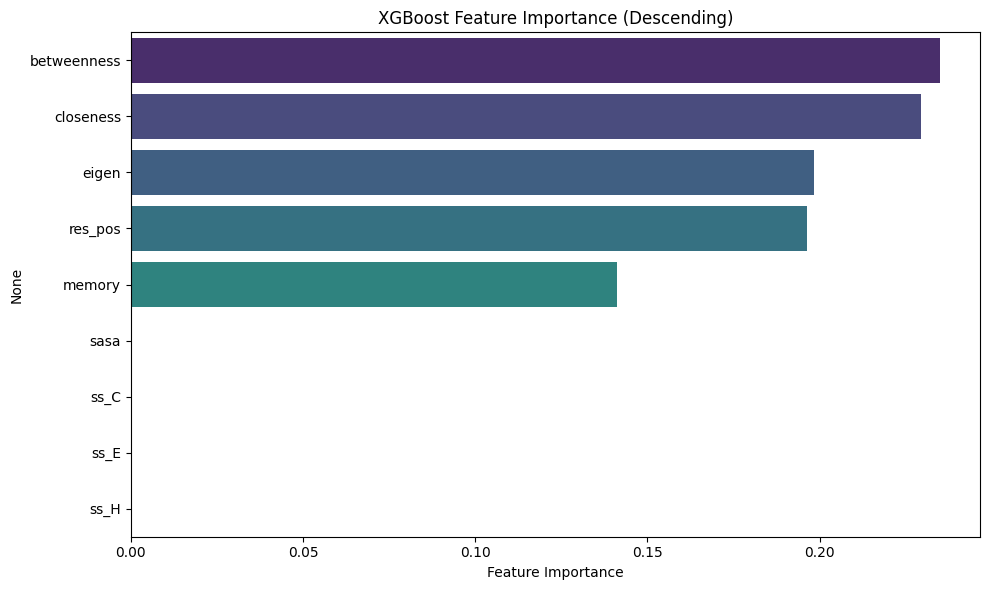

In [11]:
# This script builds protein graphs, computes centralities, trains XGBoost and GNN to predict ddG,
# and compares predictions to centrality-based top mutation sites.

import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import prody as pr
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import shap
import optuna
from xgboost import XGBRegressor
import seaborn as sns

# === Load Dataset ===
df = pd.read_csv("dataset.csv")
df = df[["pdb_id", "position", "ddG"]].dropna()
df = df[df["pdb_id"].str.len() == 4]
df = df.sample(frac=0.1).reset_index(drop=True)

records = []
features = []
targets = []

# === Download PDB ===
def download_pdb(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{pdb_id}.pdb", "w") as f:
            f.write(response.text)
        return f"{pdb_id}.pdb"
    return None

def one_hot_encode_ss(ss):
    encoding = {"H": [1, 0, 0], "E": [0, 1, 0], "C": [0, 0, 1]}
    return encoding.get(ss, [0, 0, 1])

def build_features(pdb_file, position, ddg):
    structure = pr.parsePDB(pdb_file)
    calphas = structure.select('protein and name CA')
    if calphas is None or len(calphas) < 10:
        return

    coords = calphas.getCoords()
    aa_ids = calphas.getResnums()
    ss = calphas.getSecstrs()
    sasa = calphas.getData("sasa")

    try:
        idx = list(aa_ids).index(int(position))
    except:
        return

    ss_feat = one_hot_encode_ss(ss[idx] if ss is not None else "C")
    sasa_val = sasa[idx] if sasa is not None else 0.0
    feat = [aa_ids[idx]/1000.0] + ss_feat + [sasa_val]  # Use residue number instead of x,y,z

    anm = pr.ANM('ANM')
    anm.buildHessian(calphas)
    anm.calcModes(n_modes=20)
    prs_matrix = pr.calcPerturbResponse(anm)[0]

    G = nx.Graph()
    for i in range(len(coords)):
        G.add_node(i)
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= 7.0:
                k_ij = 1.0 / dist**2
                q_ij = prs_matrix[i, j]
                memory_score = q_ij**2 / k_ij
                G.add_edge(i, j, weight=memory_score)

    memory = sum(d['weight'] for _, _, d in G.edges(idx, data=True))
    betweenness = nx.betweenness_centrality(G, weight="weight").get(idx, 0)
    closeness = nx.closeness_centrality(G, distance="weight").get(idx, 0)
    eigen = nx.eigenvector_centrality_numpy(G, weight="weight").get(idx, 0)

    full_feat = feat + [memory, betweenness, closeness, eigen]
    features.append(full_feat)
    targets.append(ddg)

# === Extract Features ===
for _, row in tqdm(df.iterrows(), total=len(df)):
    pdb_id, pos, ddg = row["pdb_id"], row["position"], row["ddG"]
    pdb_file = download_pdb(pdb_id)
    if pdb_file:
        build_features(pdb_file, pos, ddg)
        os.remove(pdb_file)
    gc.collect()

# === Train XGBoost with Optuna ===
X = pd.DataFrame(features, columns=["res_pos", "ss_H", "ss_E", "ss_C", "sasa", "memory", "betweenness", "closeness", "eigen"])
y = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    model = XGBRegressor(
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        n_estimators=trial.suggest_int("n_estimators", 50, 300),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        random_state=42
    )
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# === Train Final Model ===
best_params = study.best_trial.params
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# === SHAP Analysis ===
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary.png")

# === Feature Importance ===
importances = model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_features = X.columns[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (Descending)")
plt.tight_layout()
plt.savefig("xgb_feature_importance.png")

# === Binary Classification Evaluation ===
y_true_bin = [1 if val < 0 else 0 for val in y_test]
y_pred = model.predict(X_test)
y_pred_bin = [1 if val < 0 else 0 for val in y_pred]

cm = confusion_matrix(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin)
recall = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)

print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")


In [12]:
# This script builds protein graphs, computes memory and centralities, and trains a GNN to predict ddG.
# Additionally, it compares predicted top positions to centrality-based top positions and approximates RIN using physicochemical interactions.

import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests
import prody as pr
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

# === Load Dataset ===
df = pd.read_csv("dataset.csv")
df = df[["pdb_id", "position", "ddG"]].dropna()
df = df[df["pdb_id"].str.len() == 4]
df = df.sample(frac=0.3).reset_index(drop=True)

records = []
data_list = []

# === Download PDB ===
def download_pdb(pdb_id):
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    if response.status_code == 200:
        with open(f"{pdb_id}.pdb", "w") as f:
            f.write(response.text)
        return f"{pdb_id}.pdb"
    return None

def one_hot_encode_ss(ss):
    encoding = {"H": [1, 0, 0], "E": [0, 1, 0], "C": [0, 0, 1]}
    return encoding.get(ss, [0, 0, 1])

def safe_eigenvector_centrality(G):
    try:
        G.remove_nodes_from(list(nx.isolates(G)))
        if nx.is_connected(G):
            return nx.eigenvector_centrality_numpy(G, weight="weight")
        else:
            return nx.eigenvector_centrality(G, max_iter=5000, tol=1e-04, weight="weight")
    except Exception:
        return {node: 0.0 for node in G.nodes()}

def build_graph(pdb_file, position, ddg, cutoff=7.0):
    structure = pr.parsePDB(pdb_file)
    calphas = structure.select('protein and name CA')
    if calphas is None or len(calphas) < 10:
        return None

    coords = calphas.getCoords()
    aa_ids = calphas.getResnums()
    ss = calphas.getSecstrs()
    sas = calphas.getData("sasa")
    n = len(coords)
    edge_index, edge_attr = [], []
    node_feats = []

    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                edge_index += [[i, j], [j, i]]
                edge_attr += [[1.0 / dist], [1.0 / dist]]

    for i in range(n):
        feat = []
        feat += one_hot_encode_ss(ss[i] if ss is not None else "C")
        feat += [sas[i] if sas is not None else 0.0]
        feat += [aa_ids[i] / 1000.0]
        node_feats.append(feat)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    node_feats = torch.tensor(node_feats, dtype=torch.float)

    try:
        idx = list(aa_ids).index(int(position))
    except:
        return None

    anm = pr.ANM('ANM')
    anm.buildHessian(calphas, cutoff=cutoff)
    anm.calcModes(n_modes=20, turbo=False)
    prs_matrix = pr.calcPerturbResponse(anm)[0]

    G = nx.Graph()
    for i in range(n):
        G.add_node(i, coords=coords[i])
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist <= cutoff:
                k_ij = 1.0 / dist**2
                q_ij = prs_matrix[i, j]
                memory_score = q_ij**2 / k_ij
                G.add_edge(i, j, weight=memory_score)

    memory_scores = {i: sum(d['weight'] for _, _, d in G.edges(i, data=True)) for i in G.nodes()}
    betweenness = nx.betweenness_centrality(G, weight="weight")
    closeness = nx.closeness_centrality(G, distance="weight")
    eigen = safe_eigenvector_centrality(G)

    central_scores = [memory_scores, betweenness, closeness, eigen]
    central_ranks = {
        name: sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]
        for scores, name in zip(central_scores, ["memory", "betweenness", "closeness", "eigen"])
    }

    top_hits = {
        name: any(idx == i for i, _ in top10)
        for name, top10 in central_ranks.items()
    }

    records.append({
        "pdb_id": os.path.basename(pdb_file),
        "position": position,
        "ddG": ddg,
        "is_top10_memory": top_hits["memory"],
        "is_top10_betweenness": top_hits["betweenness"],
        "is_top10_closeness": top_hits["closeness"],
        "is_top10_eigen": top_hits["eigen"]
    })

    data = Data(
        x=node_feats,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=torch.tensor([ddg], dtype=torch.float),
        pos=torch.tensor(coords, dtype=torch.float)
    )
    return data

# === Build Dataset ===
for _, row in tqdm(df.iterrows(), total=len(df)):
    pdb_id, pos, ddg = row["pdb_id"], row["position"], row["ddG"]
    pdb_file = download_pdb(pdb_id)
    if pdb_file:
        g = build_graph(pdb_file, pos, ddg)
        if g:
            data_list.append(g)
        os.remove(pdb_file)
    gc.collect()

# === Split and Train ===
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

class GNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, 32)
        self.regressor = nn.Linear(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        pooled = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))
        return self.regressor(pooled)

model = GNN(in_channels=data_list[0].x.size(1))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# === Evaluation ===
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        pred = model(batch)
        y_true.append(batch.y.item())
        y_pred.append(pred.item())

y_true_bin = [1 if y < 0 else 0 for y in y_true]
y_pred_bin = [1 if y < 0 else 0 for y in y_pred]

cm = confusion_matrix(y_true_bin, y_pred_bin)
precision = precision_score(y_true_bin, y_pred_bin)
recall = recall_score(y_true_bin, y_pred_bin)
f1 = f1_score(y_true_bin, y_pred_bin)
print("\nConfusion Matrix:")
print(cm)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

match_df = pd.DataFrame(records)
for metric in ["memory", "betweenness", "closeness", "eigen"]:
    rate = match_df[f"is_top10_{metric}"].mean()
    print(f"Top-10 match rate for {metric}: {rate:.2%}")

/var/folders/77/wfv9nbcd5t94hwcgvb3vzvwr0000gn/T/ipykernel_2351/2308107114.py:24: DtypeWarning: Columns (23,24,25,26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")
  0%|          | 0/911 [00:00<?, ?it/s]@> 545 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> Hessian was built in 0.00s.
@> WARNING More than 6 (7) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.01s.
  0%|          | 1/911 [00:00<09:05,  1.67it/s]@> 1842 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Hessian was built in 0.01s.
@> WARNING More than 6 (13) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.05s.
  0%|          | 2/911 [00:01<13:18,  1.14it/s]@> 1364 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> Hessian was built in 0.01s.
@> WARNING More than 6 (9) zero eigenvalues were calculated.
@> Solving for additiona

Epoch 1, Loss: 2121.9181
Epoch 2, Loss: 2092.4452
Epoch 3, Loss: 2087.3596
Epoch 4, Loss: 2093.3368
Epoch 5, Loss: 2087.6406
Epoch 6, Loss: 2091.1861
Epoch 7, Loss: 2086.6605
Epoch 8, Loss: 2084.7875
Epoch 9, Loss: 2089.6795
Epoch 10, Loss: 2087.0102

Confusion Matrix:
[[94  0]
 [69  0]]
Precision: 0.000, Recall: 0.000, F1 Score: 0.000
Top-10 match rate for memory: 16.36%
Top-10 match rate for betweenness: 8.86%
Top-10 match rate for closeness: 8.61%
Top-10 match rate for eigen: 8.73%


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
